# Apache Spark Movie Recommendation System

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import os
from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType, LongType, StringType
from pyspark.sql import functions as f
from pyspark.sql.functions import col, size, split, udf
from pyspark.mllib.recommendation import ALS
os.environ["PYSPARK_PYTHON"] = "python3"

## Data ETL, Data Exploration, Data Cleaning

In [4]:
spark = SparkSession \
    .builder \
    .appName("moive analysis") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [5]:
movies = spark.read.load("/FileStore/tables/small_data/movies.csv", format='csv', inferSchema = True, header = True)
ratings = spark.read.load("/FileStore/tables/ratings.csv", format='csv', inferSchema = True, header = True)
links = spark.read.load("/FileStore/tables/links.csv", format='csv', inferSchema = True, header = True)
tags = spark.read.load("/FileStore/tables/tags.csv", format='csv', inferSchema = True, header = True)

In [6]:
print("movies schema")
movies.printSchema()
print("ratings schema")
ratings.printSchema()
print("links schema")
links.printSchema()
print("tags schema")
tags.printSchema()

ratings = ratings.select(ratings["userId"].cast("int"), ratings["movieId"].cast("int"), ratings["rating"].cast("float"), ratings["timestamp"].cast("int"))
links = links.select(links["movieId"].cast("int"), links["imdbId"].cast("int"), links["tmdbId"].cast("int"))
tags = tags.select(tags["userId"].cast("int"), tags["movieId"].cast("int"), tags["timestamp"].cast("int"))

movies schema
root
-- movieId: integer (nullable = true)
-- title: string (nullable = true)
-- genres: string (nullable = true)

ratings schema
root
-- userId: integer (nullable = true)
-- movieId: integer (nullable = true)
-- rating: double (nullable = true)
-- timestamp: integer (nullable = true)

links schema
root
-- movieId: integer (nullable = true)
-- imdbId: integer (nullable = true)
-- tmdbId: integer (nullable = true)

tags schema
root
-- userId: integer (nullable = true)
-- movieId: integer (nullable = true)
-- tag: string (nullable = true)
-- timestamp: string (nullable = true)

In [7]:
# the missing valuea are not in movie dataset and rating dataset hence I did nothing in this preoject. I am only focusing on the movie and ratings.
print("Missing Value")
df_ls = [movies, ratings, links, tags]
name_ls = ["movies", "ratings", "links", "tags"]
i = 0
for data in df_ls:
  for column in data.columns:
    print("Number of NULLs in column {} of {} data:".format(column, name_ls[i]),
          data.where(col(column).isNull()).count())
  i += 1

Missing Value
Number of NULLs in column movieId of movies data: 0
Number of NULLs in column title of movies data: 0
Number of NULLs in column genres of movies data: 0
Number of NULLs in column userId of ratings data: 0
Number of NULLs in column movieId of ratings data: 0
Number of NULLs in column rating of ratings data: 0
Number of NULLs in column timestamp of ratings data: 0
Number of NULLs in column movieId of links data: 0
Number of NULLs in column imdbId of links data: 0
Number of NULLs in column tmdbId of links data: 181
Number of NULLs in column userId of tags data: 0
Number of NULLs in column movieId of tags data: 0
Number of NULLs in column timestamp of tags data: 2

## Exploring Data Analysis Spark SQL and OLAP - Get Insights of Data

In [9]:
# The number of Users: 
print("number of Users: ", ratings.select('userId').distinct().count())

# The number of Movies:
print("number of Movies: ", movies.select('movieId').distinct().count())

number of Users: 283228
number of Movies: 9742

In [10]:
# Create interface for SparkSQL
movies.createOrReplaceTempView("Movies")
ratings.createOrReplaceTempView("Ratings")

# How many movies are rated by users?
movies_count_rated = spark.sql("SELECT COUNT(DISTINCT(Movies.movieId)) AS movies\
                              FROM Movies \
                              LEFT JOIN Ratings \
                                     ON Movies.movieId = Ratings.movieId \
                              WHERE Ratings.rating IS NOT NULL")
movies_count_rated.show(truncate = False)

# How many movies are not rated by users? What are they?
movies_not_rated = spark.sql("SELECT Movies.title AS movies_not_rated_before\
                              FROM Movies \
                              LEFT JOIN Ratings \
                                     ON Movies.movieId = Ratings.movieId \
                              WHERE Ratings.rating IS NULL")
movies_not_rated.show(truncate = False)

#What is the distribution of number of ratings for each movie:
movies_rate_situation = spark.sql("SELECT Movies.title, COUNT(Ratings.rating) AS NumberofRating\
                                   FROM Movies \
                                   LEFT JOIN Ratings \
                                        ON Movies.movieId = Ratings.movieId \
                                   GROUP BY Movies.title \
                                   ORDER BY NumberofRating")
movies_rate_situation = movies_rate_situation.toPandas()

print("How many movies are not rated by users?", movies_not_rated.count())

print("cold rating: ")
print(movies_rate_situation.sort_values(by = ["NumberofRating"], ascending = True).head(5))
print("\n")
print("Top frequent ratings: ")
print(movies_rate_situation.sort_values(by = ["NumberofRating"], ascending = False).head(5))
print("\n")
print("descriptive analysis on number of ratings")
print(movies_rate_situation["NumberofRating"].describe())
print("\n")
print("number of movies that only have one rating")
print(movies_rate_situation[movies_rate_situation["NumberofRating"] < 2].count())

+------+
movies|
+------+
9742 |
+------+

+-----------------------+
movies_not_rated_before|
+-----------------------+
+-----------------------+

How many movies are not rated by users? 0
cold rating: 
 title NumberofRating
0 Silver Spoon (2014) 1
28 Iron Soldier (2010) 1
27 Der Herr Karl (1961) 1
26 Tilt (2011) 1
25 Flint (2017) 1


Top frequent ratings: 
 title NumberofRating
9736 Shawshank Redemption, The (1994) 97999
9735 Forrest Gump (1994) 97040
9734 Pulp Fiction (1994) 92406
9733 Silence of the Lambs, The (1991) 87899
9732 Matrix, The (1999) 84545


descriptive analysis on number of ratings
count 9737.000000
mean 2750.585191
std 6446.367942
min 1.000000
25% 193.000000
50% 642.000000
75% 2171.000000
max 97999.000000
Name: NumberofRating, dtype: float64


number of movies that only have one rating
title 29
NumberofRating 29
dtype: int64

In [11]:
from pyspark.sql.functions import split, explode
movies_new = movies.withColumn("genres_split", explode(split(movies.genres, '\|')))
movies_new.show(10)

+-------+--------------------+--------------------+------------+
movieId| title| genres|genres_split|
+-------+--------------------+--------------------+------------+
 1| Toy Story (1995)|Adventure|Animati...| Adventure|
 1| Toy Story (1995)|Adventure|Animati...| Animation|
 1| Toy Story (1995)|Adventure|Animati...| Children|
 1| Toy Story (1995)|Adventure|Animati...| Comedy|
 1| Toy Story (1995)|Adventure|Animati...| Fantasy|
 2| Jumanji (1995)|Adventure|Childre...| Adventure|
 2| Jumanji (1995)|Adventure|Childre...| Children|
 2| Jumanji (1995)|Adventure|Childre...| Fantasy|
 3|Grumpier Old Men ...| Comedy|Romance| Comedy|
 3|Grumpier Old Men ...| Comedy|Romance| Romance|
+-------+--------------------+--------------------+------------+
only showing top 10 rows

In [12]:
genre_list = movies_new.select("genres_split").distinct()
genre_list = genre_list.withColumnRenamed("genres_split", "genre_list").toPandas()
print("Number of Genres: ", len(genre_list))
print(genre_list)

Number of Genres: 20
 genre_list
0 Crime
1 Romance
2 Thriller
3 Adventure
4 Drama
5 War
6 Documentary
7 Fantasy
8 Mystery
9 Musical
10 Animation
11 Film-Noir
12 (no genres listed)
13 IMAX
14 Horror
15 Western
16 Comedy
17 Children
18 Action
19 Sci-Fi

In [13]:
# aggregate all the movie with same genres
movie_each_cat = movies_new.groupBy("genres_split").agg(f.concat_ws(", ", f.collect_list(movies["title"])))
movie_each_cat = movie_each_cat.withColumnRenamed("concat_ws(, , collect_list(title))", "movie_list")
movie_each_cat = movie_each_cat.withColumn("movie_list2", split("movie_list", ","))

# Count the nnumber of movies per genres
movie_list2len = udf(lambda s: len(s), IntegerType())
movie_each_cat = movie_each_cat.select("genres_split", "movie_list", movie_list2len("movie_list").alias("num_of_movies"))
movie_each_cat = movie_each_cat.orderBy("num_of_movies", ascending = False)
movie_each_cat_for_display = movie_each_cat.take(5)
display(movie_each_cat_for_display)

genres_split movie_list num_of_movies Drama Waiting to Exhale (1995), American President, The (1995), Nixon (1995), Casino (1995), Sense and Sensibility (1995), Money Train (1995), Copycat (1995), Powder (1995), Leaving Las Vegas (1995), Othello (1995), Now and Then (1995), Persuasion (1995), City of Lost Children, The (Cité des enfants perdus, La) (1995), Shanghai Triad (Yao a yao yao dao waipo qiao) (1995), Dangerous Minds (1995), Babe (1995), Dead Man Walking (1995), Cry, the Beloved Country (1995), Richard III (1995), Dead Presidents (1995), Restoration (1995), To Die For (1995), How to Make an American Quilt (1995), Pocahontas (1995), When Night Is Falling (1995), Mighty Aphrodite (1995), Lamerica (1994), Georgia (1995), Home for the Holidays (1995), Postman, The (Postino, Il) (1994), Eye for an Eye (1996), Mr. Holland's Opus (1995), Kicking and Screaming (1995), Misérables, Les (1995), Bed of Roses (1996), Big Bully (1996), Crossing Guard, The (1995), Juror, The (1996), White Balloon, The (Badkonake sefid) (1995), Things to Do in Denver When You're Dead (1995), Antonia's Line (Antonia) (1995), Once Upon a Time... When We Were Colored (1995), Angels and Insects (1995), White Squall (1996), Mary Reilly (1996), Beautiful Girls (1996), In the Bleak Midwinter (1995), Hate (Haine, La) (1995), City Hall (1996), Bridges of Madison County, The (1995), Nobody Loves Me (Keiner liebt mich) (1994), Braveheart (1995), Taxi Driver (1976), Before and After (1996), Young Poisoner's Handbook, The (1995), Boys of St. Vincent, The (1992), Chungking Express (Chung Hing sam lam) (1994), Up Close and Personal (1996), Bad Boys (1995), Basketball Diaries, The (1995), Awfully Big Adventure, An (1995), Amateur (1994), Apollo 13 (1995), Rob Roy (1995), Addiction, The (1995), Beauty of the Day (Belle de jour) (1967), Beyond Rangoon (1995), Blue in the Face (1995), Clockers (1995), Crimson Tide (1995), Doom Generation, The (1995), First Knight (1995), Free Willy 2: The Adventure Home (1995), Jeffrey (1995), Kids (1995), Love & Human Remains (1993), Mad Love (1995), Nadja (1994), Scarlet Letter, The (1995), Showgirls (1995), Smoke (1995), Something to Talk About (1995), Strange Days (1995), Umbrellas of Cherbourg, The (Parapluies de Cherbourg, Les) (1964), Three Wishes (1995), Total Eclipse (1995), Unstrung Heroes (1995), Walk in the Clouds, A (1995), White Man's Burden (1995), Browning Version, The (1994), Burnt by the Sun (Utomlyonnye solntsem) (1994), Before the Rain (Pred dozhdot) (1994), Before Sunrise (1995), Babysitter, The (1995), Boys on the Side (1995), Cure, The (1995), Circle of Friends (1995), Don Juan DeMarco (1995), Disclosure (1994), Death and the Maiden (1994), Dolores Claiborne (1995), Eat Drink Man Woman (Yin shi nan nu) (1994), Exotica (1994), Ed Wood (1994), Fluke (1995), Farinelli: il castrato (1994), Heavenly Creatures (1994), Immortal Beloved (1994), Interview with the Vampire: The Vampire Chronicles (1994), Jefferson in Paris (1995), Kiss of Death (1995), Little Women (1994), Little Princess, A (1995), Ladybird Ladybird (1994), Like Water for Chocolate (Como agua para chocolate) (1992), Legends of the Fall (1994), My Crazy Life (Mi vida loca) (1993), Love Affair (1994), Losing Isaiah (1995), Madness of King George, The (1994), Mary Shelley's Frankenstein (Frankenstein) (1994), Miracle on 34th Street (1994), My Family (1995), Murder in the First (1995), Nobody's Fool (1994), Nell (1994), New Jersey Drive (1995), Beyond Bedlam (1993), Once Were Warriors (1994), Poison Ivy II (1996), Outbreak (1995), Léon: The Professional (a.k.a. The Professional) (Léon) (1994), Pulp Fiction (1994), Pushing Hands (Tui shou) (1992), Priest (1994), Quiz Show (1994), Picture Bride (Bijo photo) (1994), Queen Margot (Reine Margot, La) (1994), Roommates (1995), Three Colors: Red (Trois couleurs: Rouge) (1994), Three Colors: Blue (Trois couleurs: Bleu) (1993), Three Colors: White (Trzy kolory: Bialy) (1994), Secret of Roan Inish, The (1994), Specialist

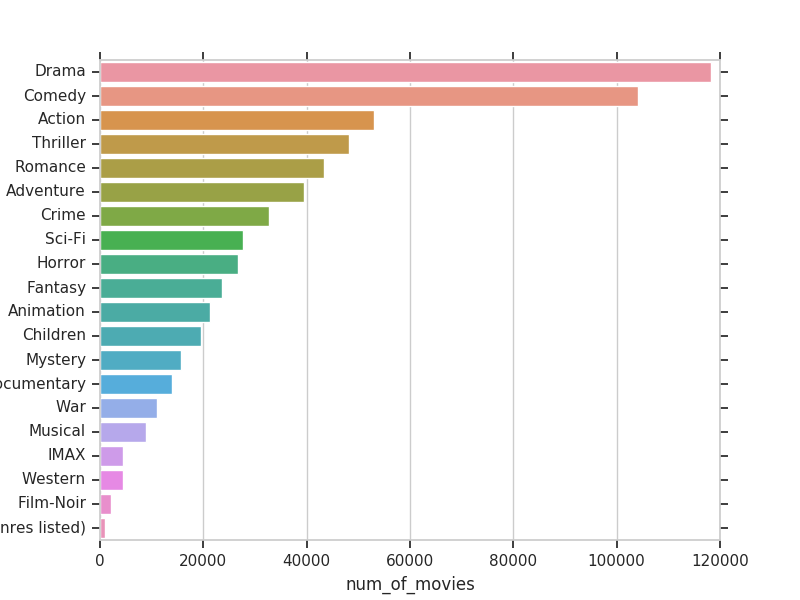

In [14]:
movie_each_cat_df = movie_each_cat.toPandas()
fig = plt.figure(figsize=(8,6))
sns.set(style = "whitegrid", rc={"lines.linewidth": 4.5})
sns.barplot(x = "num_of_movies", y = "genres_split", data = movie_each_cat_df)
display(fig)

In [15]:
movies_new.createOrReplaceTempView("Movies2")
ratings.createOrReplaceTempView("Ratings")
genres_avg_rate = spark.sql("SELECT Movies2.genres_split, AVG(Ratings.rating) AS AVGofRating\
                                   FROM Movies2 \
                                   LEFT JOIN Ratings \
                                        ON Movies2.movieId = Ratings.movieId \
                                   GROUP BY Movies2.genres_split \
                                   ORDER BY AVGofRating")
genres_avg_rate = genres_avg_rate.toPandas()
print(genres_avg_rate)
print(genres_avg_rate["AVGofRating"].describe())

genres_split AVGofRating
0 Horror 3.312783
1 Comedy 3.427841
2 Children 3.432677
3 Action 3.468952
4 Sci-Fi 3.478374
5 Fantasy 3.513021
6 Adventure 3.518704
7 Thriller 3.529415
8 Romance 3.548326
9 Musical 3.551856
10 Western 3.591256
11 Animation 3.618077
12 IMAX 3.620068
13 (no genres listed) 3.631326
14 Mystery 3.678358
15 Drama 3.690873
16 Crime 3.693513
17 Documentary 3.768574
18 War 3.807552
19 Film-Noir 3.944373
count 20.000000
mean 3.591296
std 0.146852
min 3.312783
25% 3.504359
50% 3.571556
75% 3.681487
max 3.944373
Name: AVGofRating, dtype: float64

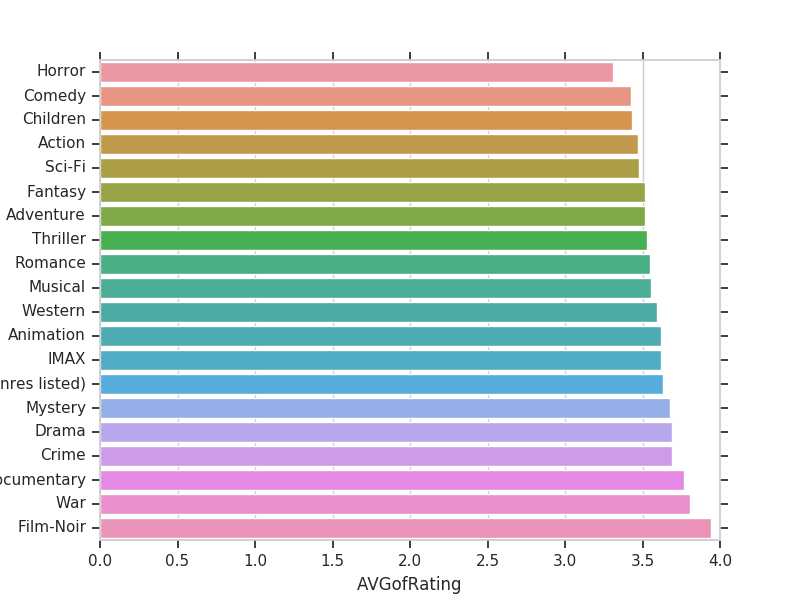

In [16]:
fig = plt.figure(figsize=(8,6))
sns.set(style = "whitegrid", rc={"lines.linewidth": 4.5})
sns.barplot(x = "AVGofRating", y = "genres_split", data = genres_avg_rate)
display(fig)

## Modeling: Spark ALS Based Approach

In [18]:
movie_rating = sc.textFile("/FileStore/tables/ratings.csv")
header = movie_rating.take(1)[0]
rating_data = movie_rating.filter(lambda line: line!=header).\
              map(lambda line: line.split(",")).\
              map(lambda tokens: (int(tokens[0]), int(tokens[1]), float(tokens[2]))).cache()
rating_data.take(3)

Out[ 12 ]: [(1, 307, 3.5), (1, 481, 3.5), (1, 1091, 1.5)]

In [19]:
train, validation, test = rating_data.randomSplit([0.6,0.2,0.2], seed = 7856)
train.cache()
validation.cache()
test.cache()

Out[ 13 ]: PythonRDD[217] at RDD at PythonRDD.scala:56

In [20]:
def train_ALS(train_data, validation_data, num_iters, reg_param, ranks):
    min_error = float('inf')
    best_rank = -1
    best_regularization = 0
    best_model = None
    for rank in ranks:
        for reg in reg_param:
            # train ALS model
            model = ALS.train(train, iterations, rank, lambda_ = reg)
            # make prediction
            validation_data = validation.map(lambda p: (p[0], p[1]))  # select userID, movieId
            predictions = model.predictAll(validation_data).map(lambda r: ((r[0], r[1]), r[2]))  # predict the rating
            # get the rating result and compare the actual val
            ratesAndPreds = validation.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)  # join the actual val and predicted val
            # get the RMSE
            RMSE = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()**0.5  # root mean square error
            print ('{} latent factors and regularization = {}: validation RMSE is {}'.format(rank, reg, RMSE))
            if RMSE < min_error:
                min_error = RMSE
                best_rank = rank
                best_regularization = reg
                best_model = model                
    print('\nThe best model has {} latent factors and regularization = {}'.format(best_rank, best_regularization))
    return best_model

In [21]:
iterations = 10
ranks = [6, 8, 10, 12, 14]
reg_params = [0.05, 0.1, 0.2, 0.4, 0.8]

import time
start_time = time.time()
final_model = train_ALS(train, validation, iterations, reg_params, ranks)
print ('Total Runtime: {:.2f} seconds'.format(time.time() - start_time))

6 latent factors and regularization = 0.05: validation RMSE is 0.8262428857082984
6 latent factors and regularization = 0.1: validation RMSE is 0.8271783312103546
6 latent factors and regularization = 0.2: validation RMSE is 0.8568986481294616
6 latent factors and regularization = 0.4: validation RMSE is 0.9533294352580142
6 latent factors and regularization = 0.8: validation RMSE is 1.1821240529840842
8 latent factors and regularization = 0.05: validation RMSE is 0.8234660318528748
8 latent factors and regularization = 0.1: validation RMSE is 0.8252277174433398
8 latent factors and regularization = 0.2: validation RMSE is 0.8654442281329078
8 latent factors and regularization = 0.4: validation RMSE is 0.9578618907031079
8 latent factors and regularization = 0.8: validation RMSE is 1.185048884139704
10 latent factors and regularization = 0.05: validation RMSE is 0.818705155043388
10 latent factors and regularization = 0.1: validation RMSE is 0.8191698797395992
10 latent factors and regularization = 0.2: validation RMSE is 0.866225709716756
10 latent factors and regularization = 0.4: validation RMSE is 0.9619044473380736
10 latent factors and regularization = 0.8: validation RMSE is 1.1853090398099024
12 latent factors and regularization = 0.05: validation RMSE is 0.8180734680221454
12 latent factors and regularization = 0.1: validation RMSE is 0.8190984634756947
12 latent factors and regularization = 0.2: validation RMSE is 0.8679512541331642
12 latent factors and regularization = 0.4: validation RMSE is 0.9618481719268237

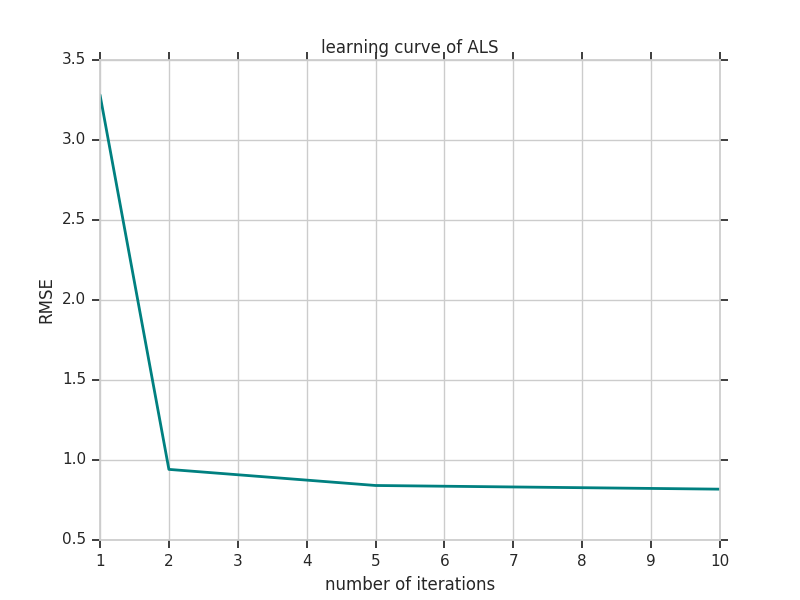

In [22]:
iter_array = [1, 2, 5, 10]
final_rank = 14
final_regularization = 0.05

# plot the learning curve 
def plot_learning_curve(iter_array, train, validation, final_regularization, final_rank):
  
    RMSE_ls = []
    
    for num_iter in iter_array:
        # train ALS model
        model = ALS.train(train, rank = final_rank, lambda_ = final_regularization, iterations = num_iter)
        # make prediction
        validation_data = validation.map(lambda p: (p[0], p[1]))  # select userID, movieId
        predictions = model.predictAll(validation_data).map(lambda r: ((r[0], r[1]), r[2]))  # predict the rating
        # get the rating result and compare the actual val
        ratesAndPreds = validation.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)  # join the actual val and predicted val
        # get the RMSE
        RMSE_ls.append(ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()**0.5)  # mean square error
        
    fig = plt.figure()
    sns.set(style = "whitegrid")
    plt.plot(iter_array, RMSE_ls, linewidth = 2, color = "teal")
    plt.legend(loc = "upper left")
    plt.title("learning curve of ALS")
    plt.xlabel("number of iterations")
    plt.ylabel("RMSE")
    display(fig)
    
plot_learning_curve(iter_array, train, validation, final_regularization, final_rank)
# ALS models has converged to a reasonably good solution after 2 iterations

### Model testing
And finally, make a prediction and check the testing error.

In [24]:
# make a prediction
testdata = test.map(lambda p: (p[0], p[1]))
predictions = final_model.predictAll(testdata).map(lambda r: ((r[0], r[1]), r[2]))
predictions.take(20)

Out[ 20 ]: 
[((18624, 150), 3.546137740939435),
 ((18624, 750), 3.9952506338594267),
 ((18624, 1234), 3.867101605109333),
 ((18624, 178), 3.501710165444667),
 ((18624, 162), 3.623536538869977),
 ((18624, 474), 3.601822578154846),
 ((18624, 151), 3.802256523134729),
 ((18624, 943), 3.577353496048488),
 ((18624, 223), 3.724193290598588),
 ((18624, 508), 3.9121911110676915),
 ((18624, 1348), 3.545937464385),
 ((18624, 533), 2.5889968087860993),
 ((18624, 539), 3.5077896970141618),
 ((18624, 1265), 3.518446202733147),
 ((18624, 953), 3.6229066310292275),
 ((18624, 1295), 4.08420870815682),
 ((18624, 1247), 4.094625854068248),
 ((18624, 1103), 3.8534761452943296),
 ((18624, 1213), 3.881452093308073),
 ((18624, 171), 4.126461339824619)]

In [25]:
# Evaluate the model on testing data
ratesAndPreds = test.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
RMSE = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()**0.5
print("Root Mean Squared Error = " + str(RMSE))

Root Mean Squared Error = 0.8137004755042353

The Root Mean Squared Error is 0.886 which is smaller than the error of validation dataset 0.896. The model is well performed

### Situation: 
The given data is from MovieLens Latest Datasets that contains four datasets: movies, ratings, links, tags, and movies dataset will be the target data for this project.


### Task: 
The goal is to build a recommendation system based on user rating data.


### Action:
#### 1. Data Exploration and Cleaning
1. Use Spark DataFrame to load the data
2. Since I am only focusing on the movie and rating data, and both of them have no missing values, so I keep the rest there.
3. Count the number of movies(9742) and users(283228) for a brief understanding of the data

#### 2. Exploring Data Analysis Spark SQL and OLAP -  Get Insights of Data
1. Check the Ratings for Each Movie: After the examination, all movies have at least one rating. A movie has 2750 ratings on average while there are still 29 movies that only with one rating.
2. See which type of the genres is most commonly used by the movies
3. The average score for the entire genres is 3.59, and the standard deviation is 0.15. This indicates that most of the ratings are the even in different genres. Types like Film-Noir, war, Documentary, and Crime had higher ratings than the others, and those movies are usually involved with exaggerating the truth in the film. 

#### 3. Modeling: Spark ALS Based Approach
1. Reload the data again in RDD format then split the model into training, validation, and test set. 
2. Make a training function that includes hyperparameter tunning including rank, lambda(regularization term), and draw a learning curve plot to find the best number of iterations. The learning curve is to find the optimal number of iterations to lessen 80% potential the computing cost(10 -> 2 iterations) in the future. In the plot, we can see that only 2 iteration can reach good results instead of 10 iterations. 
3. Evaluate the model using root mean square error, which is a regression based method.

### 4. Result and future work
1. I achieve the model with 0.8146 error in ALS which is very similiar to the results on the validation data. The best model has 14 latent factors and regularization = 0.05
2. To solve cold start problem, the spark ALS only support unrated items or new users to NULL values or just dropped them. This problem may be done by using the item-based collaborating method in the future.

In [28]:
# dbutils.fs.rm("dbfs:/FileStore/tables/links.csv", True)